In [ ]:
!pip install -q pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [ ]:
import pandas as pd
import numpy as np
import pyomo.environ as pyo

# Problema

Su jefe le ha solicitador revisar su modelo de optimización teniendo en cuenta los siguientes cambios:

1. Aumento de las capacidades de la plantas de Ciudad de México de 5050 a 5500 toneladas y de Monterrey de 4000 a 4500 toneladas.

2. Por falta de un insumo, la planta de Monterrey no podrá hacer ningún envío a la sucursal de Zacatecas, y el 100% del pedido de esta sala deberá ser surtido por la planta de Ciudad de México.

Utilice como base el código de Python desarrollado en esta sección (haz una copia) y contesta las siguientes preguntas:

Preguntas de esta tarea
¿Cuál es el costo total de transporte del modelo de optimización? ¿Es mayor o menor al visto en clase? ¿A qué se debe el cambio?

De la tabla "Análisis de Sensibilidad por Fábricas:"

¿Cuál es la holgura de las plantas? ¿Cuál es el valor sombra de la planta de Ciudad de México? ¿De dónde sale este número?

Ayuda: Guarda los resultados (copia y pega) del modelo de optimización. Vuelve a correr el modelo aumentando una unidad de capacidad en la planta de Ciudad de México. Compara los resultados con los del modelo original. Luego analiza los costos de los envíos que cambiaron debido al aumento de capacidad.

De la tabla "Análisis de Sensibilidad por Sucursales:"

¿Cuál es el valor sombra de la sucursal León? ¿De qué planta se están enviando los productos de la sucursal de León? ¿Cuál es el costo de envío por tonelada desde esta fábrica hasta León? ¿Cómo explicas la diferencia?

Ayuda: En primera lugar, asegúrate de tener los valores de capacidad originales (corrige la capacidad de Ciudad de México a 5500 toneladas que modificaste en la pregunta anterior). Luego, vuelve a correr el modelo aumentando la demanda de León en una unidad. Compara los resultados con los del modelo original. Además de Léon, ¿cambiaron otros envíos? Suma el costos de envío de la unidad adicional con el de los costos asociados a los cambios en otras sucursales.

# Paramétros del modelo

In [ ]:
# Diccionario de demandas totales para cada cliente mayorista

Demanda = {
   'GDA':    943,        # Guadalaja
   'ZAC':   1320,        # Zacatecas
   'AGU':   1694,        # Aguascalientes
   'PVA':   1885,        # Puerto Vallarta
   'TOR':   1700,        # Torreón
   'LEO':   1508         # León
}

Demanda

{'GDA': 943, 'ZAC': 1320, 'AGU': 1694, 'PVA': 1885, 'TOR': 1700, 'LEO': 1508}

In [ ]:
# Diccionario de la oferta de cada planta de producción

Oferta = {
   'CDMX':   5500,        # Ciudad de México
   'MTY' :   4500         # Monterrey
}

Oferta

{'CDMX': 5500, 'MTY': 4500}

In [ ]:
# Diccionario de costo de transporte ($/TON)por cliente mayorista y planta de producci´pn

Costos = {
    ('GDA','CDMX'): 1102,
    ('GDA','MTY') : 1614,
    ('ZAC','CDMX'): 1256,
    ('ZAC','MTY') :  930,
    ('AGU','CDMX'):  990,
    ('AGU','MTY') : 1146,
    ('PVA','CDMX'): 1762,
    ('PVA','MTY') : 2276,
    ('TOR','CDMX'): 2024,
    ('TOR','MTY') :  668,
    ('LEO','CDMX'):  758,
    ('LEO','MTY') : 1392
}
Costos

{('GDA', 'CDMX'): 1102,
 ('GDA', 'MTY'): 1614,
 ('ZAC', 'CDMX'): 1256,
 ('ZAC', 'MTY'): 930,
 ('AGU', 'CDMX'): 990,
 ('AGU', 'MTY'): 1146,
 ('PVA', 'CDMX'): 1762,
 ('PVA', 'MTY'): 2276,
 ('TOR', 'CDMX'): 2024,
 ('TOR', 'MTY'): 668,
 ('LEO', 'CDMX'): 758,
 ('LEO', 'MTY'): 1392}

# Se instancia el problema y se crea tambien la clase para realizar el analisis de sensibilidad

**Explicación sobre los diferencias entre las clases pyo.ConcreteModel() y Suffix()**

- pyo.ConcreteModel:
Represents a concrete optimization model in Pyomo.
Concrete models contain:

      Sets: Represent collections of unique elements.

      Parameters: Represent data that can be modified.

      Variables: Represent the unknown quantities to be determined by the optimization solver.

      Constraints: Represent the restrictions that the variables must satisfy.

      Objectives: Represent the goals to be achieved by the optimization solver.

- pyo.Suffix:
Represents a suffix, which is a way to extend or modify an existing Pyomo object.
In this case, modelo.dual = pyo.Suffix(direction = pyo.Suffix.IMPORT) creates a suffix called dual on the modelo object.
The direction = pyo.Suffix.IMPORT argument specifies that the suffix will be used to import data from an external source, such as a file or another Pyomo model.

In [ ]:
modelo = pyo.ConcreteModel()
modelo.dual = pyo.Suffix(direction = pyo.Suffix.IMPORT)

# Variables de decisión

Correponden a las toneladas de producto enviadas desde las diferentes fábricas hacia las diferentes sucursales, tendríamos 12 variables de decisión

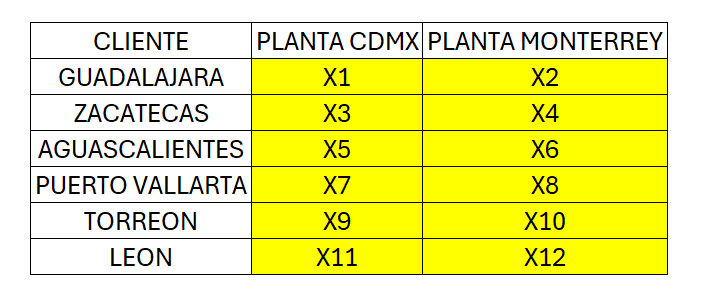

In [ ]:
# creamos la lista de clientes y plantas para definir la matriz de variables de decisión
FABRICAS = list(Oferta.keys())
SUCURSALES = list(Demanda.keys())

FABRICAS, SUCURSALES

(['CDMX', 'MTY'], ['GDA', 'ZAC', 'AGU', 'PVA', 'TOR', 'LEO'])

In [ ]:
# Definicion de las variables de decision
modelo.x = pyo.Var(SUCURSALES, FABRICAS, domain = pyo.NonNegativeReals)

# Función objetivo

La función a minimizar son los costos de transporte por tonelada de producto

In [ ]:
# lista para guardar el producto entre cada variables de decisión (Ton de producto) por el Costo/TON
fo_min = []

# Multiplicación
for s in SUCURSALES:
  for f in FABRICAS:
    fo_min.append(
        Costos[s,f]*modelo.x[s,f]
    )

# Definicion de la FO
modelo.CostoTransporte = pyo.Objective(
    expr  = sum(fo_min),
    sense = pyo.minimize
)

# Definicion de restricciones

Restricción 1: Las Ton de productos que se envian a todos los clientes mayoristas desde cada planta deben ser menor o igual a la oferta (capacidad maxima de cada planta)

In [ ]:
modelo.restriccionfabrica = pyo.ConstraintList()

for f in FABRICAS:
    modelo.restriccionfabrica.add(sum([modelo.x[s,f] for s in SUCURSALES]) <= Oferta[f])

Restricción 2: Las toneladas que se le envían a cada clientes desde cada fabricas deben ser iguales al total de la demanda estimada de ese cliente

In [ ]:
modelo.restriccionsucursal = pyo.ConstraintList()
for s in SUCURSALES:
    modelo.restriccionsucursal.add(sum([modelo.x[s,f] for f in FABRICAS]) == Demanda[s])

Restricción 3: Por falta de insumo la planta de Monterrey  no podrá hacer envios a la sucursal de Zacatecas, el 100% del pedido debe ser surtido por la planta de CDMX

In [ ]:
modelo.restriccionZAC_MTY = pyo.ConstraintList()

modelo.restriccionZAC_MTY.add(sum([modelo.x['ZAC','MTY']]) == 0)

# Solución del problema:

GLPK (GNU Linear Programming Kit) es un solver de programación lineal y entera que se integra con Pyomo, una biblioteca de modelado algebraico en Pytho

In [ ]:
solucion = pyo.SolverFactory('glpk').solve(modelo)

In [ ]:
solucion.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 10318336.0
  Upper bound: 10318336.0
  Number of objectives: 1
  Number of constraints: 9
  Number of variables: 12
  Number of nonzeros: 25
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.007027387619018555
# ----------------------------------------------------------
#   Solution Information
# ------------------------

# Variables de decisión y costos totales


In [ ]:
print(f"Costo Total de Transporte ${modelo.CostoTransporte():,.0f} pesos MX")
print("Con los siguientes envíos:")
for f in FABRICAS:
    for s in SUCURSALES:
        if modelo.x[s,f]() > 0:
            print(f"Envíe desde la fábrica en {f} a la sucursal en {s}: {modelo.x[s,f]():,.0f} Toneladas")

Costo Total de Transporte $10,318,336 pesos MX
Con los siguientes envíos:
Envíe desde la fábrica en CDMX a la sucursal en GDA: 787 Toneladas
Envíe desde la fábrica en CDMX a la sucursal en ZAC: 1,320 Toneladas
Envíe desde la fábrica en CDMX a la sucursal en PVA: 1,885 Toneladas
Envíe desde la fábrica en CDMX a la sucursal en LEO: 1,508 Toneladas
Envíe desde la fábrica en MTY a la sucursal en GDA: 156 Toneladas
Envíe desde la fábrica en MTY a la sucursal en AGU: 1,694 Toneladas
Envíe desde la fábrica en MTY a la sucursal en TOR: 1,700 Toneladas


# Analisis de sensibilidad

In [ ]:
print("Análisis de Sensibilidad por Fábrica")
print("Fábrica          Holgura Precio Sombra")
for i in modelo.restriccionfabrica.keys():
    f = FABRICAS[i-1]
    print("{0:10s}{1:10.1f}{2:10.1f}".format(f, (Oferta[f] - modelo.restriccionfabrica[i]()), modelo.dual[modelo.restriccionfabrica[i]]))

Análisis de Sensibilidad por Fábrica
Fábrica          Holgura Precio Sombra
CDMX             0.0    -512.0
MTY            950.0       0.0


In [ ]:
print("Análisis de Sensibilidad por Sucursal")
print("Sucursal       Holgura  Precio Sombra")
for j in modelo.restriccionsucursal.keys():
    s = SUCURSALES[j-1]
    print("{0:10s}{1:10.1f}{2:10.1f}".format(s, (modelo.restriccionsucursal[j]() - Demanda[s]), modelo.dual[modelo.restriccionsucursal[j]]))

Análisis de Sensibilidad por Sucursal
Sucursal       Holgura  Precio Sombra
GDA              0.0    1614.0
ZAC              0.0    1768.0
AGU              0.0    1146.0
PVA              0.0    2274.0
TOR              0.0     668.0
LEO              0.0    1270.0


La holgura explica que tantas ton de producto quedaron faltando para usar por completo las restricciones de oferta y demanda, en este caso la holgura es de cero en cada caso.

el precio sombra indica cual sería el costo adicional por tonelada de producto que se envíe como adicional.

